In [1]:
# import sys
# import os

# sys.path.append(os.path.abspath("../code"))

In [5]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from torch_functions import *

from plot_data import *
from data_loading import *

import json

from ellipsoid_predictor import *
from hyper_rectangles import *


In [ ]:
seed_everything(42)

config_name = "energy001"

config_path = "../parameters/" + config_name + ".json"
with open(config_path, 'r') as file : 
    parameters = json.load(file)


prop_train = parameters["prop_train"]
prop_calibration = parameters["prop_calibration"]

# Chemin d'entrée et de sortie
load_path = "../data/processed_data/" + parameters["load_name"] + ".npz"

# Exemple d'utilisation du loader
X, Y = load_data(load_path)

# Load Data
load_path = "../data/processed_data/" + parameters["load_name"] + ".npz"
X, Y = load_data(load_path)


normalize = parameters["normalize"]
splits = [parameters["prop_train"], parameters["prop_stop"], parameters["prop_calibration"], parameters["prop_test"]]

subsets = split_and_preprocess(X, Y, splits=splits, normalize=normalize)

x_train, y_train, x_calibration, y_calibration, x_test, y_test, x_stop, y_stop = subsets["X_train"], subsets["Y_train"], subsets["X_calibration"], subsets["Y_calibration"], subsets["X_test"], subsets["Y_test"], subsets["X_stop"], subsets["Y_stop"]

print("X_train shape:", x_train.shape, "Y_train shape:", y_train.shape)
print("X_cal shape:", x_calibration.shape, "Y_cal shape:", y_calibration.shape)
print("X_test shape:", x_test.shape, "Y_test shape:", y_test.shape)
print("X_stop shape:", x_stop.shape, "Y_stop shape:", y_stop.shape)

d = x_train.shape[1]
k = y_train.shape[1]

n_train = x_train.shape[0]
n_test = x_test.shape[0]
n_calibration = x_calibration.shape[0]
n_stop = x_stop.shape[0]

hidden_dim = parameters["hidden_dim"]
hidden_dim_matrix = parameters["hidden_dim_matrix"]
n_hidden_layers = parameters["n_hidden_layers"]
n_hidden_layers_matrix = parameters["n_hidden_layers_matrix"]

num_epochs_warm_start = parameters["num_epochs_warm_start"]
warm_start_epochs_mat = parameters["warm_start_epochs_mat"]
num_epochs_our_loss = parameters["num_epochs_our_loss"]

lr_warm_start = parameters["lr_warm_start"]
lr_model = parameters["lr_model"]
lr_matrix = parameters["lr_matrix"]
lr_q = parameters["lr_q"]

batch_size_warm_start = parameters["batch_size_warm_start"]
batch_size_our_loss = parameters["batch_size_our_loss"]

n_neighbors = parameters["n_neighbors"]
use_lr_scheduler = parameters["use_lr_scheduler"]
keep_best = parameters["keep_best"]

num_epochs_rectangles = parameters["num_epochs_rectangles"]
lr_rectangles = parameters["lr_rectangles"]
batch_size_rectangles = parameters["batch_size_rectangles"]

loss_strategy = parameters["loss_strategy"]
use_epsilon = parameters["use_epsilon"]

alpha = parameters["alpha"]
print(alpha)

X_train shape: (422, 8) Y_train shape: (422, 2)
X_cal shape: (115, 8) Y_cal shape: (115, 2)
X_test shape: (116, 8) Y_test shape: (116, 2)
X_stop shape: (115, 8) Y_stop shape: (115, 2)
0.01


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (422). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (422). n_quantiles is set to n_samples.
  warnings.warn(


Type de y_train : <class 'numpy.ndarray'>
Shape de y_train : (422, 2)
Aperçu des 10 premières valeurs : [[-0.18260637 -0.37476066]
 [-0.62847745 -0.49591768]
 [ 0.86043614  0.56096435]
 [ 2.0260918   2.3454854 ]
 [-0.15241468 -0.14037839]
 [ 0.08644038  0.03275281]
 [ 0.12836239  0.07449369]
 [ 0.41013047  0.3304067 ]
 [ 0.03275281  0.01190829]
 [ 0.3241253   0.8306423 ]]
Min: -5.199337482452393, Max: 5.199337482452393
Moyenne: -6.046340331522515e-06, Médiane: -3.7369318306446075e-08, Écart-type: 1.0481959581375122


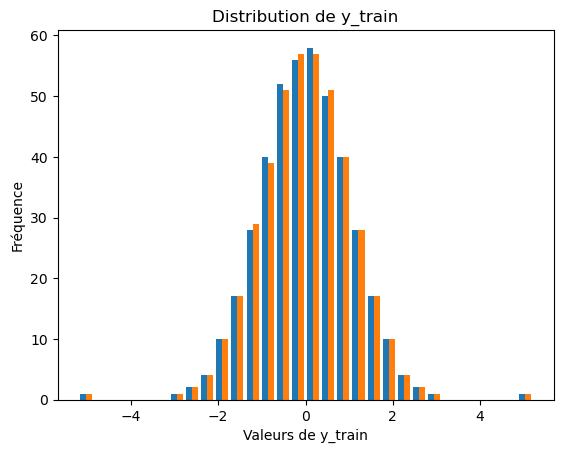

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Infos générales
print(f"Type de y_train : {type(y_train)}")
print(f"Shape de y_train : {y_train.shape}")

# Aperçu des premières valeurs
print("Aperçu des 10 premières valeurs :", y_train[:10])

# Statistiques générales
print(f"Min: {np.min(y_train)}, Max: {np.max(y_train)}")
print(f"Moyenne: {np.mean(y_train)}, Médiane: {np.median(y_train)}, Écart-type: {np.std(y_train)}")

# Vérification si y_train est catégoriel ou continu
unique, counts = np.unique(y_train, return_counts=True)
if len(unique) < 20:  # Suppose que <20 valeurs uniques signifie classification
    print("\nRépartition des classes :")
    for u, c in zip(unique, counts):
        print(f"Classe {u}: {c} occurrences")
    
    # Affichage sous forme de barres pour une classification
    plt.bar(unique, counts)
    plt.xlabel("Classes")
    plt.ylabel("Nombre d’occurrences")
    plt.title("Répartition des classes dans y_train")
else:
    # Affichage sous forme d'histogramme pour une régression
    plt.hist(y_train, bins=30)
    plt.xlabel("Valeurs de y_train")
    plt.ylabel("Fréquence")
    plt.title("Distribution de y_train")

plt.show()

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_stop_tensor = torch.tensor(x_stop, dtype=torch.float32)
y_stop_tensor = torch.tensor(y_stop, dtype=torch.float32)
x_calibration_tensor = torch.tensor(x_calibration, dtype=torch.float32)
y_calibration_tensor = torch.tensor(y_calibration, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [8]:

matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix)
model = Network(d, k, hidden_dim=hidden_dim, n_hidden_layers=n_hidden_layers)
q = torch.tensor(2.0, requires_grad=True)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size_warm_start, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size_warm_start, shuffle=True)
train_losses, stop_losses = model.fit_and_plot(trainloader, stoploader, epochs=num_epochs_warm_start, lr=lr_warm_start, keep_best=keep_best)

warm_start_model = copy.deepcopy(model)



Network with  3 hidden layers and a hidden dimension of  256


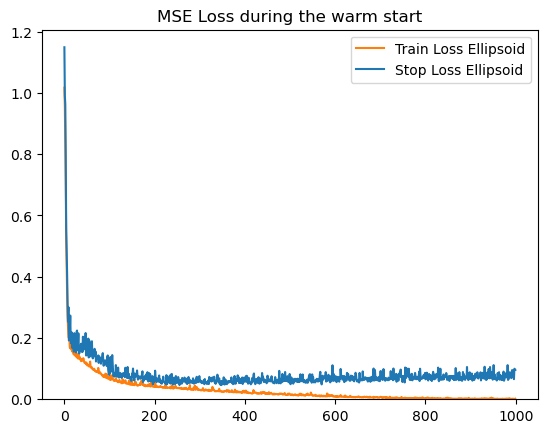

0.04627426
255


In [9]:
# Define colors for each model
half_ellipsoid_color = 'tab:blue'
ellipsoid_color = 'tab:orange'

plt.plot(train_losses, linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
plt.plot(stop_losses, linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')

plt.title("MSE Loss during the warm start")
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.close()

print(np.min(stop_losses))
print(np.argmin(stop_losses))

In [10]:
# batch_size_our_loss = 200
# lr_matrix = 0.01
# lr_q = 0.01
# lr_model = 0.0005
# warm_start_epochs_mat = 20

model = copy.deepcopy(warm_start_model)
matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size_our_loss, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size_our_loss, shuffle=True)
calibrationloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_calibration_tensor, y_calibration_tensor), batch_size= batch_size_our_loss, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor), batch_size= batch_size_our_loss, shuffle=True)

ellipsoid_predictor = EllipsoidPredictor(model, matrix_model, q)

ellipsoid_predictor.fit(trainloader, 
                        stoploader, 
                        alpha,
                        num_epochs = num_epochs_our_loss,
                        num_epochs_mat_only = warm_start_epochs_mat,
                        lr_model =lr_model,
                        lr_q = lr_q,
                        lr_matrix_model = lr_matrix,
                        use_lr_scheduler = use_lr_scheduler,
                        verbose = 2,
                        stop_on_best = keep_best,
                        loss_strategy = loss_strategy,
                        use_epsilon = use_epsilon,
                        )

New best stop loss: 10.78040599822998
Epoch 0: Loss = 11.937723159790039 - Stop Loss = 10.78040599822998 - Best Stop Loss = 10.78040599822998
New best stop loss: 8.969264030456543
Epoch 1: Loss = 14.414377212524414 - Stop Loss = 8.969264030456543 - Best Stop Loss = 8.969264030456543
Epoch 2: Loss = 11.159456253051758 - Stop Loss = 12.233783721923828 - Best Stop Loss = 8.969264030456543
Epoch 3: Loss = 10.660734176635742 - Stop Loss = 10.099515914916992 - Best Stop Loss = 8.969264030456543
Epoch 4: Loss = 7.507327079772949 - Stop Loss = 9.239484786987305 - Best Stop Loss = 8.969264030456543
New best stop loss: 6.996866703033447
Epoch 5: Loss = 6.278364658355713 - Stop Loss = 6.996866703033447 - Best Stop Loss = 6.996866703033447
New best stop loss: 6.762093544006348
Epoch 6: Loss = 6.664071083068848 - Stop Loss = 6.762093544006348 - Best Stop Loss = 6.762093544006348
New best stop loss: 6.615228652954102
Epoch 7: Loss = 6.803795337677002 - Stop Loss = 6.615228652954102 - Best Stop Loss 

In [11]:
ellipsoid_predictor.load_best_model()

In [12]:
from covariances import *
from local_covariances import *

In [13]:
model_final_loss_calibration = ellipsoid_predictor.model.eval(calibrationloader)
warm_start_model_loss_calibration = warm_start_model.eval(calibrationloader)

if model_final_loss_calibration < warm_start_model_loss_calibration:
    covariance_predictor = CovariancePredictor(ellipsoid_predictor.model)
    local_covariance_predictor = LocalCovariancePredictor(ellipsoid_predictor.model, n_neighbors=n_neighbors)

    covariance_predictor.fit(trainloader)
    local_covariance_predictor.fit(trainloader)
    print('keeping the final model')
else:
    covariance_predictor = CovariancePredictor(warm_start_model)
    local_covariance_predictor = LocalCovariancePredictor(ellipsoid_predictor.model, n_neighbors=n_neighbors)
    covariance_predictor.fit(trainloader)
    local_covariance_predictor.fit(trainloader)
    print('keeping the warm started model')

keeping the final model


In [14]:
covariance_predictor.conformalize(calibrationloader, alpha = alpha)
local_covariance_predictor.conformalize(calibrationloader, alpha = alpha)
ellipsoid_predictor.conformalize(calibrationloader, alpha = alpha)

0


In [15]:
print(ellipsoid_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))
print(covariance_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))
print(local_covariance_predictor.get_coverage(x_test=x_test_tensor, y_test=y_test_tensor))

print("")
print(ellipsoid_predictor.get_averaged_volume(x_test=x_test_tensor))
print(covariance_predictor.get_averaged_volume(x_test = x_test_tensor))
print(local_covariance_predictor.get_averaged_volume(x_test = x_test_tensor))


0.9741379022598267
0.982758641242981
0.982758641242981

1.123519778251648
1.6008272171020508
1.6008278131484985


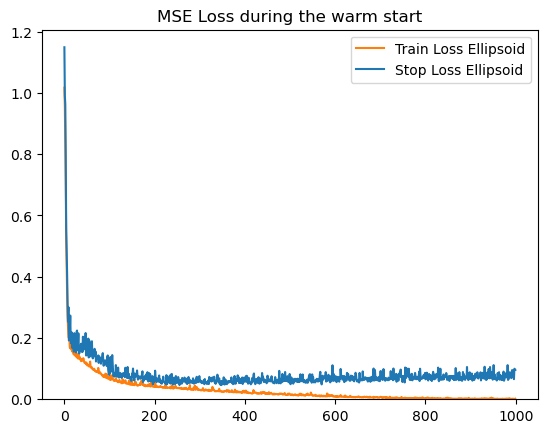

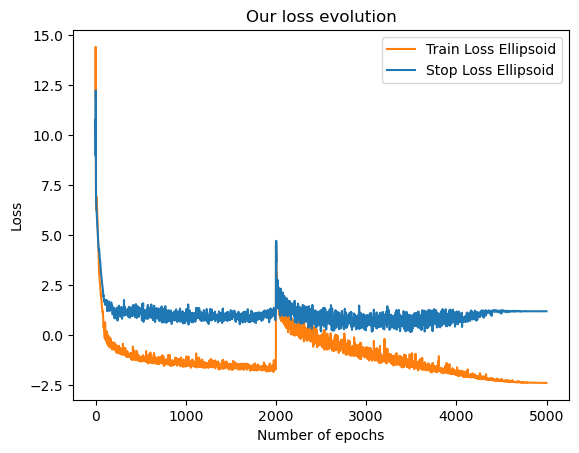

3492


In [16]:
# Define colors for each model
half_ellipsoid_color = 'tab:blue'
ellipsoid_color = 'tab:orange'

plt.plot(train_losses, linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
plt.plot(stop_losses, linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')

plt.title("MSE Loss during the warm start")
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.close()

# Second plot: Loss evolution
plt.plot(ellipsoid_predictor.tab_train_loss, linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
plt.plot(ellipsoid_predictor.tab_stop_loss, linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')
# plt.plot(ellipsoid_predictor.tab_train_loss[1000:], linestyle='-', color=ellipsoid_color, label='Train Loss Ellipsoid')
# plt.plot(ellipsoid_predictor.tab_stop_loss[1000:], linestyle='-', color=half_ellipsoid_color, label='Stop Loss Ellipsoid')

plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Our loss evolution')
plt.legend()
plt.show()
plt.close()
print(np.argmin(ellipsoid_predictor.tab_stop_loss))


In [17]:
from hyper_rectangles import *
hyper_rectangle_predictor = HyperRectanglePredictor(d,
                                                    k, 
                                                    alpha, 
                                                    hidden_dim = hidden_dim, 
                                                    n_layers = n_hidden_layers)

Network with  3 hidden layers and a hidden dimension of  256
Network with  3 hidden layers and a hidden dimension of  256
Network with  3 hidden layers and a hidden dimension of  256
Network with  3 hidden layers and a hidden dimension of  256


In [32]:
print(lr_rectangles)
lr_rectangles = 0.001

0.0001


In [33]:
# lr_rectangles = 0.0001

hyper_rectangle_predictor.fit(x_train, y_train, x_stop, y_stop,
                              num_epochs = num_epochs_rectangles, 
                              lr = lr_rectangles,
                              batch_size = batch_size_rectangles,
                              use_lr_scheduler = use_lr_scheduler,
                              verbose=2,
                              keep_best = keep_best)

Epoch 1/200, Loss: 0.0004 - Stop Loss : 0.0007 - Best Stop Loss: 0.0007 
Epoch 2/200, Loss: 0.0008 - Stop Loss : 0.0011 - Best Stop Loss: 0.0007 
Epoch 3/200, Loss: 0.0008 - Stop Loss : 0.0012 - Best Stop Loss: 0.0007 
Epoch 4/200, Loss: 0.0007 - Stop Loss : 0.0011 - Best Stop Loss: 0.0007 
Epoch 5/200, Loss: 0.0006 - Stop Loss : 0.0008 - Best Stop Loss: 0.0007 
Epoch 6/200, Loss: 0.0004 - Stop Loss : 0.0006 - Best Stop Loss: 0.0006 
Epoch 7/200, Loss: 0.0004 - Stop Loss : 0.0005 - Best Stop Loss: 0.0005 
Epoch 8/200, Loss: 0.0003 - Stop Loss : 0.0004 - Best Stop Loss: 0.0004 
Epoch 9/200, Loss: 0.0003 - Stop Loss : 0.0004 - Best Stop Loss: 0.0004 
Epoch 10/200, Loss: 0.0003 - Stop Loss : 0.0005 - Best Stop Loss: 0.0004 
Epoch 11/200, Loss: 0.0003 - Stop Loss : 0.0005 - Best Stop Loss: 0.0004 
Epoch 12/200, Loss: 0.0003 - Stop Loss : 0.0004 - Best Stop Loss: 0.0004 
Epoch 13/200, Loss: 0.0004 - Stop Loss : 0.0005 - Best Stop Loss: 0.0004 
Epoch 14/200, Loss: 0.0002 - Stop Loss : 0.0004

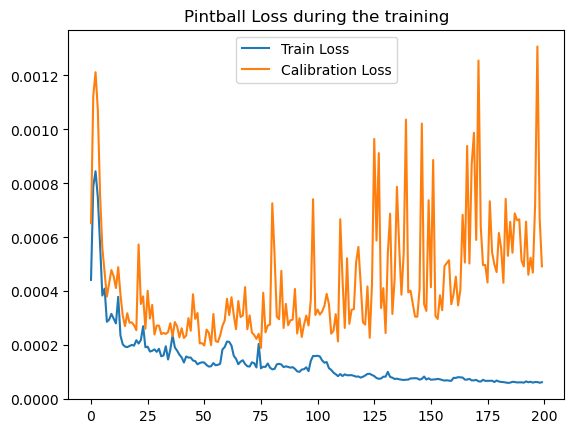

In [34]:
plt.plot(hyper_rectangle_predictor.tab_loss, label='Train Loss')
plt.plot(hyper_rectangle_predictor.tab_loss_stop, label='Calibration Loss')
plt.title("Pintball Loss during the training")
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.close()

In [35]:
hyper_rectangle_predictor.conformalize(x_calibration, y_calibration)
volume_hyper_rectangle, coverage_hyper_rectangles = hyper_rectangle_predictor.calculate_volume_and_coverage(x_test, y_test)

print(volume_hyper_rectangle)

3.8084335327148438


In [55]:
import numpy as np
import torch
from matplotlib.patches import Rectangle

def add_hyper_rectangle(ax, hyper_rectangle_predictor, x_specific, color='blue', linestyle='-', linewidth=2, label=None):
    """
    Adds a rectangle to the given plot `ax` based on predictions calculated
    from the `hyper_rectangle_predictor` and `x_specific`.

    Parameters:
        ax: matplotlib.axes.Axes
            The plot where the rectangle will be added.
        hyper_rectangle_predictor: Object
            Contains the prediction models and conformal value for bounds.
        x_specific: numpy.ndarray or similar
            The specific input for which predictions are calculated.
        color: str, optional
            The color of the rectangle's edge. Default is 'blue'.
        linestyle: str, optional
            The style of the rectangle's edge. Default is '-'.
        linewidth: float, optional
            The width of the rectangle's edge. Default is 2.
    """
    # Calculate predictions
    k = 2  # Assuming 2 dimensions for this example
    predictions = np.zeros((k, 2), dtype=float)

    for i in range(k):
        predictions[i, 0] = hyper_rectangle_predictor.tab_model_alpha_low[i](
            torch.tensor(x_specific, dtype=torch.float32).reshape(1, -1)
        ).item() - hyper_rectangle_predictor.conformal_value

        predictions[i, 1] = hyper_rectangle_predictor.tab_model_alpha_high[i](
            torch.tensor(x_specific, dtype=torch.float32).reshape(1, -1)
        ).item() + hyper_rectangle_predictor.conformal_value

    # Extract bounds for rectangle
    x_min, x_max = predictions[0]
    y_min, y_max = predictions[1]

    # Compute the width and height of the rectangle
    width = x_max - x_min
    height = y_max - y_min

    # Add the rectangle to the plot
    rectangle = Rectangle(
        (x_min, y_min), width, height,
        edgecolor=color, facecolor='none', linestyle=linestyle, linewidth=linewidth, label=label
    )
    ax.add_patch(rectangle)
    return ax


In [61]:
def add_ellipse(ax, center, Lambda, q, conformal_value, color='red', linestyle = '-', label=None):
    """
       plot -> {y, \| \Lambda (u - center) \|_q^q \leq conformal_value}  }
       conformal_value = radius ** q
    """

    # Generate a set of points on a unit circle
    theta = np.linspace(0, 2 * np.pi, 500)
    unit_circle = np.vstack((np.cos(theta), np.sin(theta)))
    
    # Scale the unit circle points to match the conformal value under the q-norm
    scaling = conformal_value * np.power(np.sum(np.abs(unit_circle) ** q, axis=0), -1/q)
    scaled_points = unit_circle * scaling
    
    # Apply the linear transformation Lambda
    transformed_points = np.linalg.inv(Lambda) @ scaled_points
    
    # Translate the ellipse to the center
    ellipse_points = transformed_points + np.reshape(center, (2, 1))
    
    # Add the ellipse to the existing plot
    ax.plot(ellipse_points[0, :], ellipse_points[1, :], label=label, c=color, linestyle=linestyle)
   #  ax.scatter(*center, color='red', label='Center')
    ax.legend()
    
    return ax

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_6261/3364570196.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_6261/3364570196.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_test[i, 0], y_test[i, 1], c=color_map(iter))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


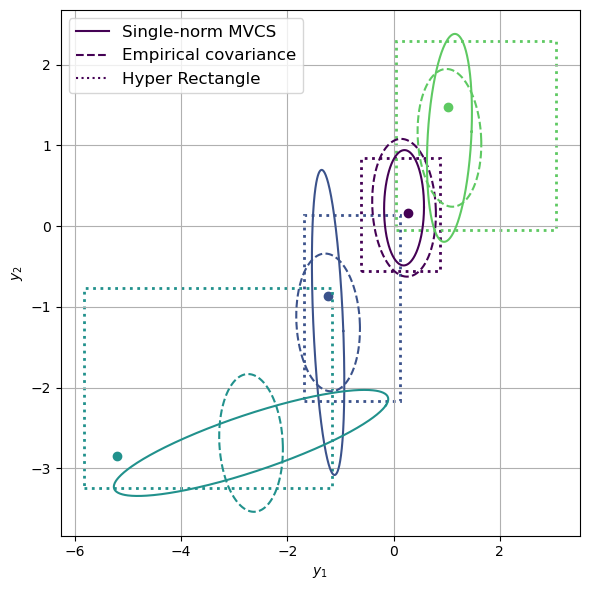

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


f_x_test = ellipsoid_predictor.model(x_test_tensor)
f_x_test_np = f_x_test.detach().numpy()
f_x_test_cov_np = ellipsoid_predictor.model(x_test_tensor).detach().numpy()

Lambdas_test = ellipsoid_predictor.get_Lambdas(x_test_tensor)
Lambdas_test_np = Lambdas_test.detach().numpy()

# Lambdas_test_cov = covariance_predictor.get_Lambdas(x_test)
Lambdas_test_cov = covariance_predictor._Lambda_cov.unsqueeze(0).expand(y_test.shape[0], y_test.shape[1], y_test.shape[1]).clone()
Lambdas_test_cov_np = Lambdas_test_cov.detach().numpy()

q_val = ellipsoid_predictor.q.item()

# Supposons que les fonctions et variables nécessaires sont déjà définies
# f_x_test_np, Lambdas_test_np, q_val, y_test, x_test, etc.

idx = [4, 5, 6, 7]

fig, ax = plt.subplots(figsize=(6, 6))

color_map = plt.cm.get_cmap('viridis', 5)
linestyles = ['-', '--', ':', '-.']  # Différents styles de ligne

# Ajouter les légendes une seule fois
legends = {
    'Single-norm MVCS': False,
    'Empirical covariance': False,
    'Hyper Rectangle': False
}

for iter, i in enumerate(idx):
    ax.scatter(y_test[i, 0], y_test[i, 1], c=color_map(iter))

    # Ajouter l'ellipse conforme
    ax = add_ellipse(ax, f_x_test_np[i], Lambdas_test_np[i], q_val, ellipsoid_predictor.nu_conformal.item(), color=color_map(iter), linestyle='-')
    if not legends['Single-norm MVCS']:
        ax.plot([], [], color=color_map(iter), linestyle=linestyles[0], label='Single-norm MVCS')
        legends['Single-norm MVCS'] = True

    # Ajouter l'ellipse conforme cov
    ax = add_ellipse(ax, f_x_test_cov_np[i], Lambdas_test_cov_np[i], 2, covariance_predictor.nu_covariance.item(), color=color_map(iter), linestyle=linestyles[1])
    if not legends['Empirical covariance']:
        ax.plot([], [], color=color_map(iter), linestyle=linestyles[1], label='Empirical covariance')
        legends['Empirical covariance'] = True

    # Ajouter l'hyper rectangle
    ax = add_hyper_rectangle(ax, hyper_rectangle_predictor, x_test[i], color=color_map(iter), linestyle=linestyles[2])
    if not legends['Hyper Rectangle']:
        ax.plot([], [], color=color_map(iter), linestyle=linestyles[2], label='Hyper Rectangle')
        legends['Hyper Rectangle'] = True

ax.grid(True)
ax.legend(loc="best")
ax.legend(fontsize=12)

ax.set_xlabel(r'$y_1$')
ax.set_ylabel(r'$y_2$')
plt.tight_layout()

plt.show()
plt.close()


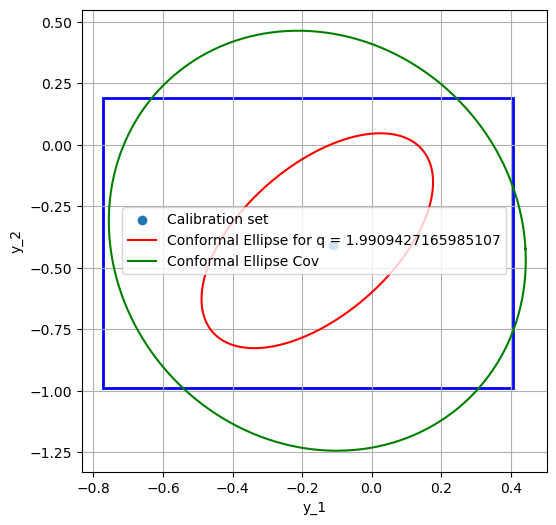

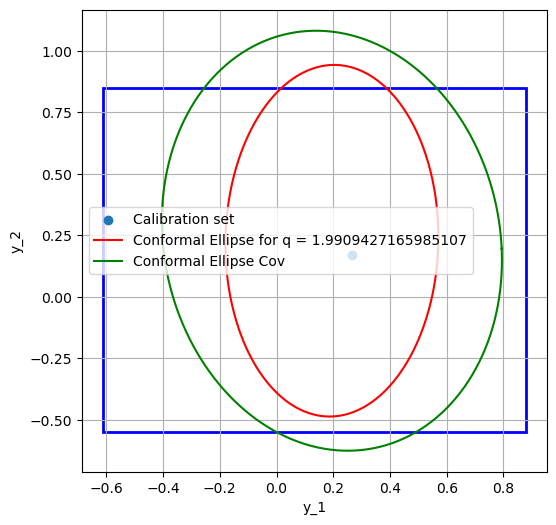

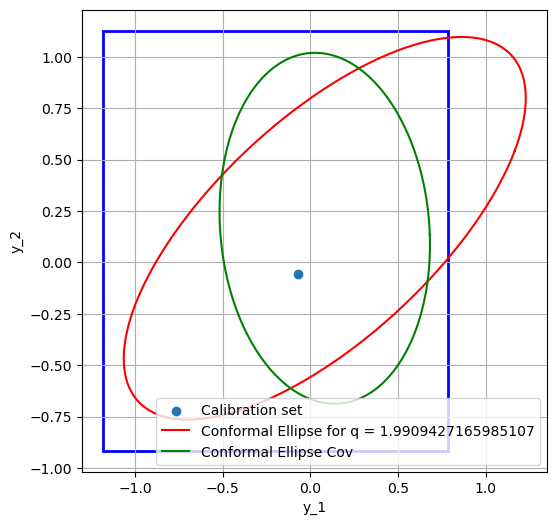

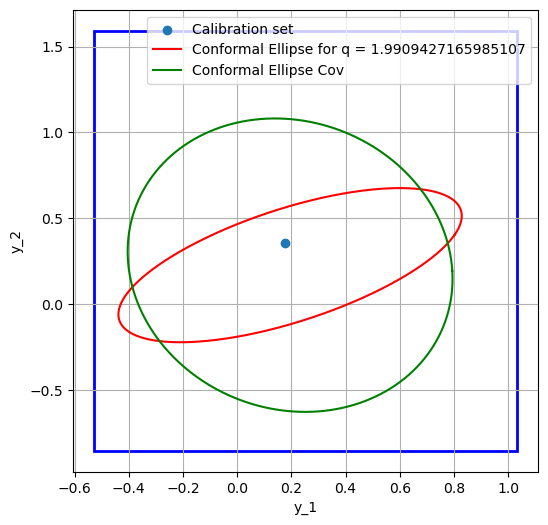

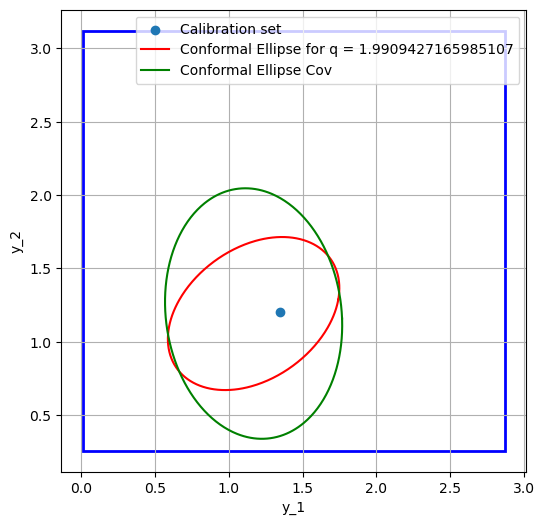

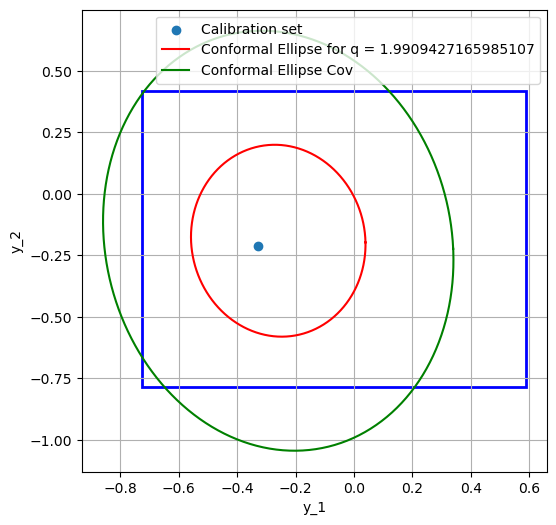

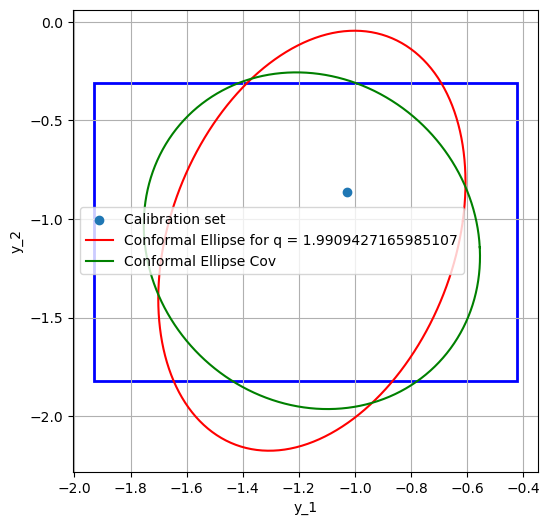

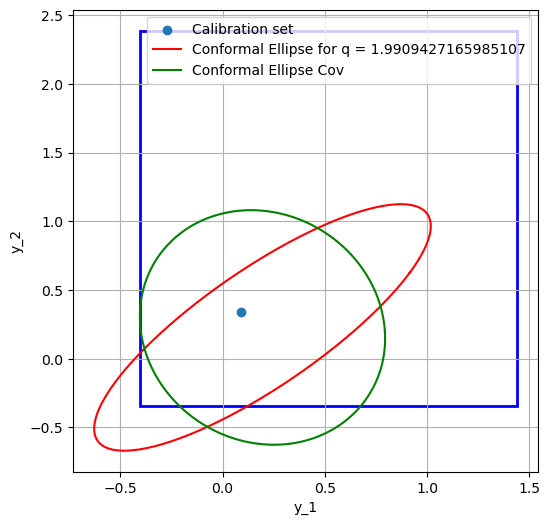

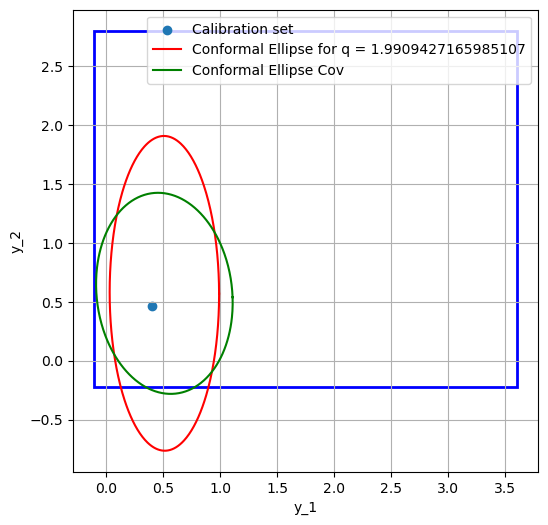

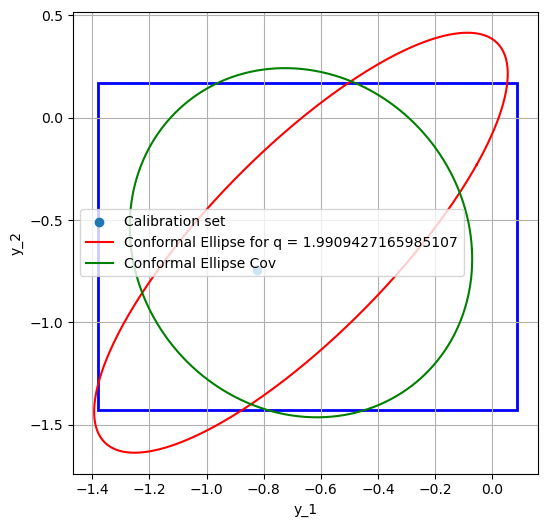

In [65]:
f_x_test = ellipsoid_predictor.model(x_test_tensor)
f_x_test_np = f_x_test.detach().numpy()
f_x_test_cov_np = ellipsoid_predictor.model(x_test_tensor).detach().numpy()

Lambdas_test = ellipsoid_predictor.get_Lambdas(x_test_tensor)
Lambdas_test_np = Lambdas_test.detach().numpy()

# Lambdas_test_cov = covariance_predictor.get_Lambdas(x_test)
Lambdas_test_cov = covariance_predictor._Lambda_cov.unsqueeze(0).expand(y_test.shape[0], y_test.shape[1], y_test.shape[1]).clone()
Lambdas_test_cov_np = Lambdas_test_cov.detach().numpy()

q_val = ellipsoid_predictor.q.item()

idx = np.random.choice(len(y_test), 10, replace=False)

for i in idx:
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # print(ellipsoid_predictor.get_averaged_volume(x_test=x_test_tensor[i]))
    # print(covariance_predictor.get_averaged_volume(x_test = x_test_tensor[i]))
    # volume_hyper_rectangle, coverage_hyper_rectangles = hyper_rectangle_predictor.calculate_volume_and_coverage(x_test[i], y_test[i])
    # print(volume_hyper_rectangle)
    ax.scatter(y_test[i, 0], y_test[i, 1], label='Calibration set')
    ax = add_ellipse(ax,  f_x_test_np[i], Lambdas_test_np[i], q_val, ellipsoid_predictor.nu_conformal.item(), color = "red", label='Conformal Ellipse for q = {}'.format(q_val))
    ax = add_ellipse(ax,  f_x_test_cov_np[i], Lambdas_test_cov_np[i], 2, covariance_predictor.nu_covariance.item(), color = "green", label='Conformal Ellipse Cov')
    ax = add_hyper_rectangle(ax, hyper_rectangle_predictor, x_test[i])
    

    ax.grid(True)
    ax.legend( loc = "best")
    
    ax.set_xlabel('y_1')
    ax.set_ylabel('y_2')

    plt.show()
    plt.close()